# Week 9 - Multivariate Analysis, part 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load dataset

import kagglehub
import os

# Download latest version

path = kagglehub.dataset_download("mrwellsdavid/unsw-nb15")
print("Path to dataset files:", path)

filename = "UNSW_NB15_training-set.csv"

# Now, construct full path to the CSV file (csv_path) and load into a DataFrame (df)

csv_path = os.path.join(path, filename)
df = pd.read_csv(csv_path)

Path to dataset files: /kaggle/input/unsw-nb15


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [6]:
pd.set_option('display.max_columns', None)
df.head(10)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.09020,254,0,1.803636e+08,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.00030,254,0,8.810000e+08,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.00510,254,0,8.544000e+08,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.66080,254,0,6.000000e+08,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.00250,254,0,8.504000e+08,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
5,6,0.000003,udp,-,INT,2,0,784,0,333333.32150,254,0,1.045333e+09,0.0,0,0,0.003,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,392,0,0,0,2,2,2,2,1,2,0,0,0,2,2,0,Normal,0
6,7,0.000006,udp,-,INT,2,0,1960,0,166666.66080,254,0,1.306667e+09,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,980,0,0,0,2,2,2,2,1,2,0,0,0,2,2,0,Normal,0
7,8,0.000028,udp,-,INT,2,0,1384,0,35714.28522,254,0,1.977143e+08,0.0,0,0,0.028,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,692,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
8,9,0.000000,arp,-,INT,1,0,46,0,0.00000,0,0,0.000000e+00,0.0,0,0,60000.688,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,46,0,0,0,2,2,2,2,2,2,0,0,0,2,2,1,Normal,0
9,10,0.000000,arp,-,INT,1,0,46,0,0.00000,0,0,0.000000e+00,0.0,0,0,60000.712,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,46,0,0,0,2,2,2,2,2,2,0,0,0,2,2,1,Normal,0


In [7]:
# Turn the categorical features into numerical features (proto, service, state, attack_cat)

df_gd = df.copy()

proto_gd = pd.get_dummies(df_gd['proto'])
service_gd = pd.get_dummies(df_gd['service'])
state_gd = pd.get_dummies(df_gd['state'])
attack_type = pd.get_dummies(df_gd['attack_cat'])

dummy_df = pd.concat([proto_gd, service_gd, state_gd, attack_type], axis=1)
dummy_df.head()

,3pc,a/n,aes-sp3-d,any,argus,aris,arp,ax.25,bbn-rcc,bna,br-sat-mon,cbt,cftp,chaos,compaq-peer,cphb,cpnx,crtp,crudp,dcn,ddp,ddx,dgp,egp,eigrp,emcon,encap,etherip,fc,fire,ggp,gmtp,gre,hmp,i-nlsp,iatp,ib,idpr,idpr-cmtp,idrp,ifmp,igmp,igp,il,ip,ipcomp,ipcv,ipip,iplt,ipnip,ippc,ipv6,ipv6-frag,ipv6-no,ipv6-opts,ipv6-route,ipx-n-ip,irtp,isis,iso-ip,iso-tp4,kryptolan,l2tp,larp,leaf-1,leaf-2,merit-inp,mfe-nsp,mhrp,micp,mobile,mtp,mux,narp,netblt,nsfnet-igp,nvp,ospf,pgm,pim,pipe,pnni,pri-enc,prm,ptp,pup,pvp,qnx,rdp,rsvp,rvd,sat-expak,sat-mon,sccopmce,scps,sctp,sdrp,secure-vmtp,sep,skip,sm,smp,snp,sprite-rpc,sps,srp,st2,stp,sun-nd,swipe,tcf,tcp,tlsp,tp++,trunk-1,trunk-2,ttp,udp,unas,uti,vines,visa,vmtp,vrrp,wb-expak,wb-mon,wsn,xnet,xns-idp,xtp,zero,-,dhcp,dns,ftp,ftp-data,http,irc,pop3,radius,smtp,snmp,ssh,ssl,ACC,CLO,CON,FIN,INT,REQ,RST,Analysis,Backdoor,DoS,Exploits,Fuzzers,Generic,Normal,Reconnaissance,Shellcode,Worms
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [8]:
# Drop columns from df_gd and concatentate

df_gd = df_gd.drop(['proto', 'service', 'state', 'attack_cat'], axis=1)

new_df_gd = pd.concat([df_gd, dummy_df], axis=1)
new_df_gd.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,3pc,a/n,aes-sp3-d,any,argus,aris,arp,ax.25,bbn-rcc,bna,br-sat-mon,cbt,cftp,chaos,compaq-peer,cphb,cpnx,crtp,crudp,dcn,ddp,ddx,dgp,egp,eigrp,emcon,encap,etherip,fc,fire,ggp,gmtp,gre,hmp,i-nlsp,iatp,ib,idpr,idpr-cmtp,idrp,ifmp,igmp,igp,il,ip,ipcomp,ipcv,ipip,iplt,ipnip,ippc,ipv6,ipv6-frag,ipv6-no,ipv6-opts,ipv6-route,ipx-n-ip,irtp,isis,iso-ip,iso-tp4,kryptolan,l2tp,larp,leaf-1,leaf-2,merit-inp,mfe-nsp,mhrp,micp,mobile,mtp,mux,narp,netblt,nsfnet-igp,nvp,ospf,pgm,pim,pipe,pnni,pri-enc,prm,ptp,pup,pvp,qnx,rdp,rsvp,rvd,sat-expak,sat-mon,sccopmce,scps,sctp,sdrp,secure-vmtp,sep,skip,sm,smp,snp,sprite-rpc,sps,srp,st2,stp,sun-nd,swipe,tcf,tcp,tlsp,tp++,trunk-1,trunk-2,ttp,udp,unas,uti,vines,visa,vmtp,vrrp,wb-expak,wb-mon,wsn,xnet,xns-idp,xtp,zero,-,dhcp,dns,ftp,ftp-data,http,irc,pop3,radius,smtp,snmp,ssh,ssl,ACC,CLO,CON,FIN,INT,REQ,RST,Analysis,Backdoor,DoS,Exploits,Fuzzers,Generic,Normal,Reconnaissance,Shellcode,Worms
0,1,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,2,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
2,3,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [9]:
# Heatmap of all features

all_corr = new_df_gd.corr()

plt.figure(figsize=(100,98))
sns.heatmap(all_corr, cmap='coolwarm', annot=False, linewidth=0.1, linecolor='black')
plt.show()

In [10]:
# Strong correlations from all_corr heatmap

corr_pairs = all_corr.unstack() # unstack the correlation matrix first

corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)] # drop self correlations

strong_corr = corr_pairs[abs(corr_pairs) > 0.5] # filter for corr above 0.4

strong_corr = strong_corr.sort_values(ascending=False).drop_duplicates() # remove duplicate pairs (a=b and b=a)

In [11]:
pd.set_option('display.max_rows', None)  # Show all rows
print(strong_corr)

tcp               swin                0.999913
dloss             dbytes              0.997109
sbytes            sloss               0.995027
is_ftp_login      ct_ftp_cmd          0.994341
dpkts             dloss               0.981506
ct_srv_src        ct_srv_dst          0.977849
dpkts             dbytes              0.976419
sloss             spkts               0.973644
sbytes            spkts               0.965750
ct_src_dport_ltm  ct_dst_ltm          0.960401
dwin              tcp                 0.960147
swin              dwin                0.960125
is_sm_ips_ports   arp                 0.958685
dwin              FIN                 0.950195
is_sm_ips_ports   sinpkt              0.944506
ct_srv_dst        ct_dst_src_ltm      0.941047
tcprtt            synack              0.939473
sinpkt            arp                 0.937803
ct_srv_src        ct_dst_src_ltm      0.933795
ct_src_ltm        ct_src_dport_ltm    0.933172
ct_dst_ltm        ct_src_ltm          0.932252
FIN          

In [12]:
# Filter for correlations that are above 0.5, and contain the target feature to analyze (attack_cat and label).

targets = new_df_gd[['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms', 'label']]

target_corr = all_corr[targets.columns]

sig_target_corr = target_corr[(abs(target_corr) > 0.3) & (abs(target_corr) < 1.0)]

sig_target_corr = sig_target_corr.dropna(how='all')

sig_target_corr

,Analysis,Backdoor,DoS,Exploits,Fuzzers,Generic,Normal,Reconnaissance,Shellcode,Worms,label
id,NaN,NaN,NaN,NaN,NaN,NaN,0.387489,NaN,NaN,NaN,-0.387489
rate,NaN,NaN,NaN,NaN,NaN,0.413375,-0.328629,NaN,NaN,NaN,0.328629
sttl,NaN,NaN,NaN,NaN,NaN,0.379624,-0.504159,NaN,NaN,NaN,0.504159
dttl,NaN,NaN,NaN,NaN,NaN,-0.414494,NaN,NaN,NaN,NaN,NaN
swin,NaN,NaN,NaN,NaN,NaN,-0.541355,0.414504,NaN,NaN,NaN,-0.414504
stcpb,NaN,NaN,NaN,NaN,NaN,-0.401375,NaN,NaN,NaN,NaN,NaN
dtcpb,NaN,NaN,NaN,NaN,NaN,-0.400011,NaN,NaN,NaN,NaN,NaN
dwin,NaN,NaN,NaN,NaN,NaN,-0.518661,0.369257,NaN,NaN,NaN,-0.369257
ct_srv_src,NaN,NaN,NaN,NaN,NaN,0.666321,NaN,NaN,NaN,NaN,NaN
ct_state_ttl,NaN,NaN,NaN,NaN,NaN,0.308778,-0.318517,NaN,NaN,NaN,0.318517


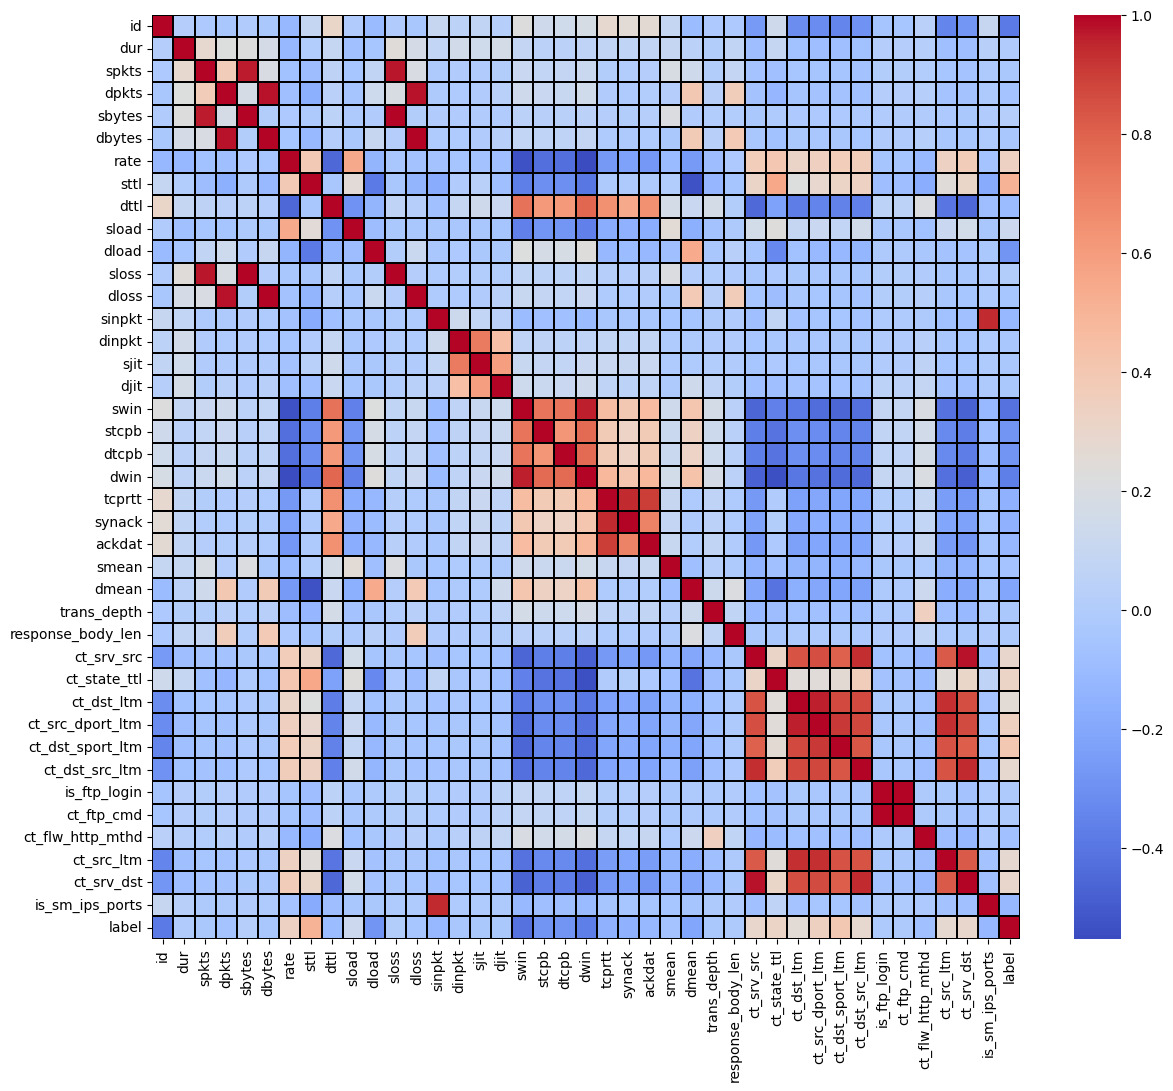

In [13]:
# Heatmap of only numerical features. Just for reference.

num_df = df_gd.select_dtypes(exclude=['object'])

correlations = num_df.corr()

plt.figure(figsize=(14,12))
sns.heatmap(correlations, cmap='coolwarm', annot=False, linewidths=0.1,linecolor='black')
plt.show()

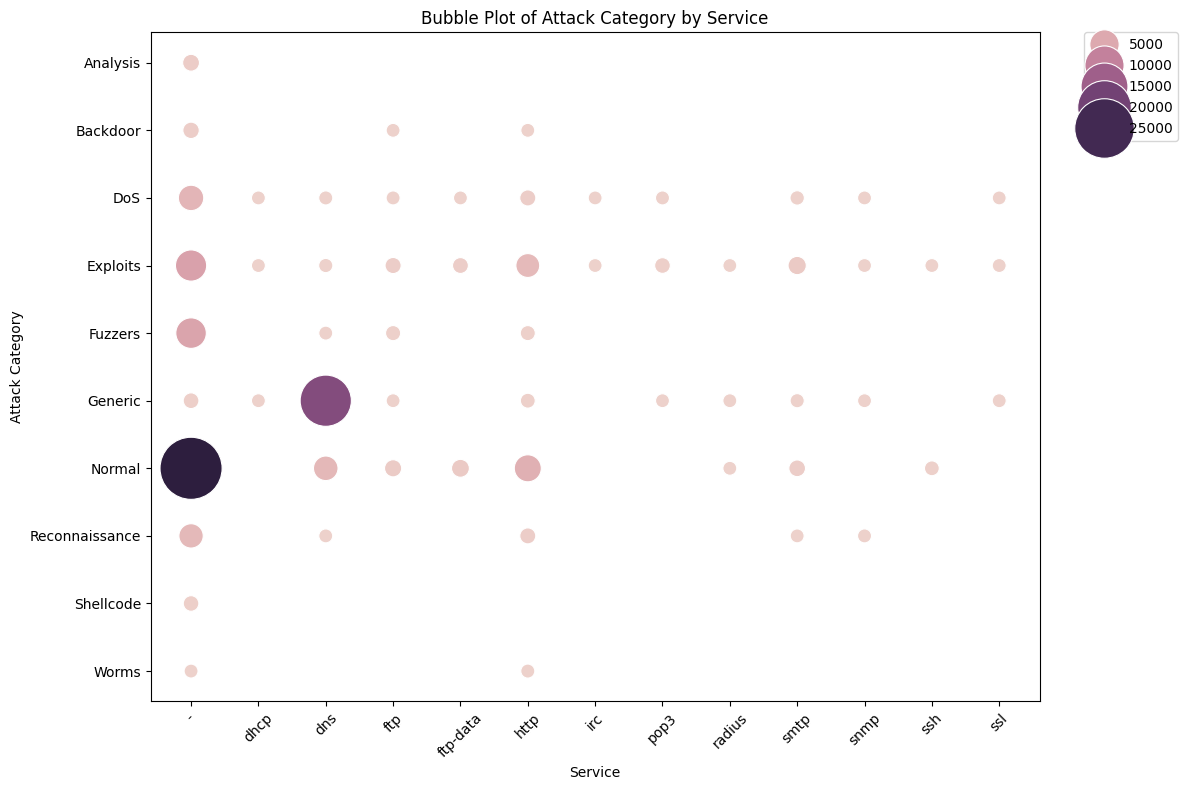

In [14]:
# Bubble Plot

bubble_df = df.groupby(['service', 'attack_cat']).size().reset_index(name='count')

plt.figure(figsize=(12,8))
bubble_plot = sns.scatterplot(
    data=bubble_df,
    x='service',
    y='attack_cat',
    size='count',
    sizes=(100, 2000),
    hue='count',
    legend='brief'
)

plt.xticks(rotation=45)
plt.title('Bubble Plot of Attack Category by Service')
plt.xlabel('Service')
plt.ylabel('Attack Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

In [15]:
# PCA

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

num_df_NL = num_df.drop(columns=['label'])

scaler = StandardScaler()

num_df_NL_scaled = scaler.fit_transform(num_df_NL)

pca = PCA(n_components=30)

pca.fit(num_df_NL_scaled)

components3 = pca.components_

print(f"PCA Component 1: {components3[0]}")
print(f"PCA Component 2: {components3[1]}")
print(f"PCA Component 3: {components3[2]}")

print("\nExplained variance ratios:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

PCA Component 1: [-0.10785469 -0.04369102 -0.04746021 -0.05943031 -0.02595073 -0.04250125
  0.19184002  0.14212329 -0.22997423  0.1068664  -0.05622733 -0.03269801
 -0.04866944 -0.00424452 -0.03077677 -0.04006833 -0.05040741 -0.25769718
 -0.2156344  -0.21510071 -0.26539543 -0.16529302 -0.14411138 -0.16275575
 -0.05875587 -0.12594086 -0.05648977 -0.02210721  0.27132566  0.15020135
  0.25767776  0.26336624  0.25844506  0.26696399 -0.02715804 -0.02702101
 -0.06537372  0.25929916  0.27388305 -0.00089139]
PCA Component 2: [-0.13925801  0.12291907  0.29252804  0.42658638  0.20775203  0.39100077
 -0.04483083 -0.14491132 -0.0502502  -0.0596989   0.1619291   0.21435068
  0.39316177 -0.04194401 -0.01414476 -0.01502351  0.02610929  0.06177896
  0.05870989  0.0580487   0.07164991 -0.09732006 -0.09193993 -0.08670668
 -0.00502709  0.26982906  0.0281123   0.19574753  0.09640683 -0.12179724
  0.11855461  0.10550159  0.09236214  0.08620372  0.01071257  0.01084252
  0.02242554  0.11292081  0.09804355 -0.

Using PCA, it is observed that 99.67% of the variance is explained by 30 components or features (out of 202).

In [16]:
num_df_NL.columns

Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [17]:

# Cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to reach 99.67%
num_components = np.argmax(cumulative_variance >= 0.9967) + 1

print(f"Number of components explaining 99.67% variance: {num_components}")


Number of components explaining 99.67% variance: 30


In [18]:
# Logistic Regression instead of Linear
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Use classification metrics instead


model = LogisticRegression(max_iter=2000)

X = new_df_gd[['rate', 'sttl', 'swin', 'dwin', 'ct_state_ttl',
            'ct_src_dport_ltm', 'ct_dst_sport_ltm',
            'tcp', 'dns', 'CON', 'FIN', 'INT']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = new_df_gd['label']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8154490799781381

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76      7418
           1       0.76      0.96      0.85      9049

    accuracy                           0.82     16467
   macro avg       0.85      0.80      0.80     16467
weighted avg       0.84      0.82      0.81     16467


Confusion Matrix:
 [[4725 2693]
 [ 346 8703]]
